# Analysis of results

## Data visualization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums

In [2]:
process_set_up = {
    "difficult_sequential": "D-SEQ",
    "difficult_parallel": "D-PAR",
    "curriculum_sequential": "C-SEQ",
    "curriculum_parallel": "C-PAR",
    "curriculum_parallel_gradual": "C-GRAD"
}
pop_size = 100

In [3]:
results_dfs = []
validation_dfs = []
progressions_dfs = []
for solver in ["cgp", "lgp"]:
    for seed in range(10):
        for set_up in process_set_up.keys():
            try:
                curr_df = pd.read_csv(f"{solver}_{set_up}_seed_{seed}_{seed}/metrics.csv")
                curr_df["seed"] = f"s_{seed}"
                curr_df["fitness_evaluation"] = curr_df["generation"] * pop_size * (3 if "parallel" in set_up else 1)
                curr_df["set_up"] = set_up
                curr_df["solver"] = solver
                curr_df["short_set_up"] = process_set_up[set_up]
                results_dfs.append(curr_df)

                val_df = pd.read_csv(f"{solver}_{set_up}_seed_{seed}_{seed}/validation.csv")
                val_df["seed"] = f"s_{seed}"
                val_df["set_up"] = set_up
                val_df["solver"] = solver
                val_df["short_set_up"] = process_set_up[set_up]
                validation_dfs.append(val_df)
                # this will only work for sequential ones
                if "sequential" in set_up:
                    progr_df = pd.read_csv(f"{solver}_{set_up}_seed_{seed}_{seed}/progression.csv")
                    progr_df["seed"] = f"s_{seed}"
                    progr_df["fitness_evaluation"] = progr_df["generation"] * pop_size * (
                        3 if "parallel" in set_up else 1)
                    progr_df["set_up"] = set_up
                    progr_df["solver"] = solver
                    progr_df["short_set_up"] = process_set_up[set_up]
                    progressions_dfs.append(progr_df)
            except FileNotFoundError as not_found:
                pass
df = pd.concat(results_dfs, ignore_index=True)
validation_df = pd.concat(validation_dfs, ignore_index=True)
sequential_progression_df = pd.concat(progressions_dfs, ignore_index=True)

/tmp/ipykernel_1082037/293329568.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(results_dfs, ignore_index=True)


In [4]:
parallel_progression_df = df[df["short_set_up"].isin(["C-PAR", "D-PAR", "C-GRAD"])][
    ["short_set_up", "set_up", "seed", "fitness_evaluation", "generation", "max_percentage", "solver"]]
parallel_progression_df = parallel_progression_df.rename(columns={"max_percentage": "avg_percentage"}, inplace=False)
progression_df = pd.concat([sequential_progression_df, parallel_progression_df], ignore_index=True)
progression_df.head()

,generation,avg_percentage,seed,fitness_evaluation,set_up,solver,short_set_up
0,0,0.023973,s_0,0,difficult_sequential,cgp,D-SEQ
1,50,0.195691,s_0,5000,difficult_sequential,cgp,D-SEQ
2,100,0.075273,s_0,10000,difficult_sequential,cgp,D-SEQ
3,150,0.144738,s_0,15000,difficult_sequential,cgp,D-SEQ
4,200,0.145496,s_0,20000,difficult_sequential,cgp,D-SEQ


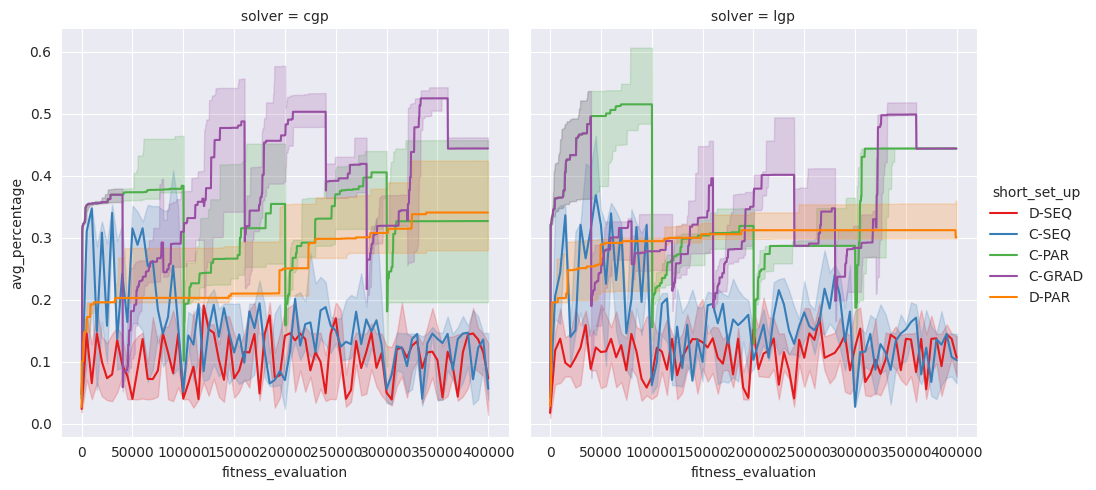

In [97]:
sns.relplot(
    data=progression_df,
    x="fitness_evaluation",
    y="avg_percentage",
    col="solver",
    hue="short_set_up",
    estimator="median",
    errorbar=("pi", 50),
    palette="Set1",
    kind="line",
)
plt.show()

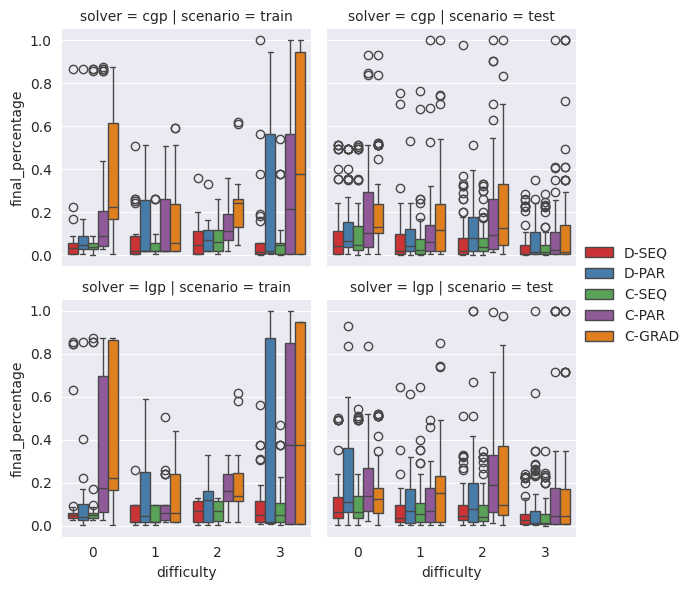

In [6]:
validation_df["difficulty"] = validation_df["prompt"].apply(
    lambda x: 3 if "many" in x else (2 if "some_pipes" in x else (
        1 if "some_enemies" in x else (0 if "no_enemies" in x else int(x.split('_')[1]))))
)
validation_df["scenario"] = validation_df["prompt"].apply(lambda x: x.split("_")[0])
fct = sns.FacetGrid(validation_df[(
        validation_df["difficulty"].isin(range(4)) & ~(validation_df["scenario"] == "original"))],
                    col="scenario", row="solver")
fct.map_dataframe(sns.boxplot, x="difficulty", y="final_percentage", hue="short_set_up", palette="Set1")
fct.add_legend()
plt.show()

In [7]:
original_validation_df = validation_df[
    (validation_df["scenario"] == "original") & ~(validation_df["short_set_up"].isin(["C1", "D1"]))]
original_median = original_validation_df.groupby(["short_set_up", "difficulty", "solver"]).median(
    "final_percentage").reset_index()
original_median["inverted_percentage"] = 1 - original_median["final_percentage"]
rank_dfs = []
for difficulty in original_median["difficulty"].unique():
    for solver in ["cgp", "lgp"]:
        curr_df = original_median[(original_median["difficulty"] == difficulty) & (original_median["solver"] == solver)]
        curr_df["rank"] = curr_df["inverted_percentage"].rank()
        rank_dfs.append(curr_df)
rank_df = pd.concat(rank_dfs, ignore_index=True)
rank_df.head()

/tmp/ipykernel_1082037/992901882.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df["rank"] = curr_df["inverted_percentage"].rank()
/tmp/ipykernel_1082037/992901882.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df["rank"] = curr_df["inverted_percentage"].rank()
/tmp/ipykernel_1082037/992901882.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,short_set_up,difficulty,solver,reward,done,dead_time,final_percentage,inverted_percentage,rank
0,C-GRAD,1,cgp,-900.831967,50.5,50.5,0.100677,0.899323,1.0
1,C-PAR,1,cgp,-906.816458,52.0,52.0,0.095463,0.904537,3.0
2,C-SEQ,1,cgp,-903.924495,52.0,52.0,0.097948,0.902052,2.0
3,D-PAR,1,cgp,-907.233127,52.0,52.0,0.095029,0.904971,4.5
4,D-SEQ,1,cgp,-907.233127,526.0,526.0,0.095029,0.904971,4.5


## Statistical tests

In [9]:
comparisons = [("C-PAR", "D-PAR"),
               ("C-GRAD", "D-PAR"),
               ("C-PAR", "C-GRAD"),
               ("C-SEQ", "D-SEQ"),
               ("C-PAR", "C-SEQ"),
               ("C-GRAD", "C-SEQ"),
               ("D-PAR", "D-SEQ")]

In [10]:
end_of_evo = progression_df.loc[
    progression_df.groupby(["seed", "solver", "short_set_up"])["generation"].idxmax()
]
for solver in ["lgp", "cgp"]:
    for m1, m2 in comparisons:
        m1_data = end_of_evo[(end_of_evo["short_set_up"] == m1) & (end_of_evo["solver"] == solver)][
            "avg_percentage"].to_list()
        m2_data = end_of_evo[(end_of_evo["short_set_up"] == m2) & (end_of_evo["solver"] == solver)][
            "avg_percentage"].to_list()
        _, pvalue = ranksums(m1_data, m2_data)
        print(f"{solver} -> {m1} vs {m2}: {pvalue:.3f}")

lgp -> C-PAR vs D-PAR: 0.054
lgp -> C-GRAD vs D-PAR: 0.016
lgp -> C-PAR vs C-GRAD: 0.385
lgp -> C-SEQ vs D-SEQ: 0.678
lgp -> C-PAR vs C-SEQ: 0.000
lgp -> C-GRAD vs C-SEQ: 0.000
lgp -> D-PAR vs D-SEQ: 0.000
cgp -> C-PAR vs D-PAR: 0.480
cgp -> C-GRAD vs D-PAR: 0.120
cgp -> C-PAR vs C-GRAD: 0.089
cgp -> C-SEQ vs D-SEQ: 0.940
cgp -> C-PAR vs C-SEQ: 0.000
cgp -> C-GRAD vs C-SEQ: 0.000
cgp -> D-PAR vs D-SEQ: 0.011


In [11]:
test_validation = validation_df[validation_df["scenario"] == "test"]
for difficulty in test_validation["difficulty"].unique():
    print(f"Difficulty {difficulty}")
    for m1, m2 in comparisons:
        m1_data = \
            test_validation[(test_validation["difficulty"] == difficulty) & (test_validation["short_set_up"] == m1)][
                "final_percentage"].to_list()
        m2_data = \
            test_validation[(test_validation["difficulty"] == difficulty) & (test_validation["short_set_up"] == m2)][
                "final_percentage"].to_list()
        _, pvalue = ranksums(m1_data, m2_data)
        print(f"{m1} vs {m2}: {pvalue:.3f}")

Difficulty 0
C-PAR vs D-PAR: 0.019
C-GRAD vs D-PAR: 0.018
C-PAR vs C-GRAD: 0.741
C-SEQ vs D-SEQ: 0.825
C-PAR vs C-SEQ: 0.000
C-GRAD vs C-SEQ: 0.000
D-PAR vs D-SEQ: 0.002
Difficulty 1
C-PAR vs D-PAR: 0.218
C-GRAD vs D-PAR: 0.002
C-PAR vs C-GRAD: 0.043
C-SEQ vs D-SEQ: 0.730
C-PAR vs C-SEQ: 0.001
C-GRAD vs C-SEQ: 0.000
D-PAR vs D-SEQ: 0.010
Difficulty 2
C-PAR vs D-PAR: 0.000
C-GRAD vs D-PAR: 0.000
C-PAR vs C-GRAD: 0.186
C-SEQ vs D-SEQ: 0.350
C-PAR vs C-SEQ: 0.000
C-GRAD vs C-SEQ: 0.000
D-PAR vs D-SEQ: 0.000
Difficulty 3
C-PAR vs D-PAR: 0.076
C-GRAD vs D-PAR: 0.053
C-PAR vs C-GRAD: 0.833
C-SEQ vs D-SEQ: 0.678
C-PAR vs C-SEQ: 0.001
C-GRAD vs C-SEQ: 0.001
D-PAR vs D-SEQ: 0.038


In [12]:
full_comparisons = [("C-PAR", "D-PAR"), ("C-SEQ", "D-SEQ"), ("C-PAR", "C-SEQ"), ("D-PAR", "D-SEQ"), ("C-PAR", "D-SEQ"),
                    ("D-PAR", "C-SEQ")]

In [13]:
original_pvalues = []
original_validation = validation_df[validation_df["scenario"] == "original"]
for difficulty in original_validation["difficulty"].unique():
    for m1, m2 in full_comparisons:
        m1_data = original_validation[
            (original_validation["difficulty"] == difficulty) & (original_validation["short_set_up"] == m1)][
            "final_percentage"].to_list()
        m2_data = original_validation[
            (original_validation["difficulty"] == difficulty) & (original_validation["short_set_up"] == m2)][
            "final_percentage"].to_list()
        _, pvalue = ranksums(m1_data, m2_data)
        original_pvalues.append({
            "m1": m1,
            "m2": m2,
            "pvalue": pvalue
        })
original_pvalues_df = pd.DataFrame(original_pvalues)
original_pvalues_df.head()

,m1,m2,pvalue
0,C-PAR,D-PAR,0.261054
1,C-SEQ,D-SEQ,0.034866
2,C-PAR,C-SEQ,0.913837
3,D-PAR,D-SEQ,0.067799
4,C-PAR,D-SEQ,0.007113


## Export data

In [147]:
data_export = False

from statistics import median
from typing import List, Union

from pandas import DataFrame


def line_plot(df: DataFrame, x: str, y: Union[List[str], str], groups: Union[List[str], str] = None,
              file_prefix: str = "", cols_joiner: str = "_", filename_joiner: str = "_"):
    """ Exports data to individual files for line plots with median as main line and shaded area between quartiles.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """

    if type(y) == str:
        y = [y]
    if type(groups) == str:
        groups = [groups]

    def q1(a):
        return a.quantile(0.25)

    def q3(b):
        return b.quantile(0.75)

    vals = dict([(key, [q1, q3, median]) for key in y])

    summary = df.groupby(groups + [x]).agg(vals)
    summary.columns = [cols_joiner.join(col) for col in summary.columns.to_flat_index()]
    summary.reset_index(inplace=True)

    key_df = df.drop_duplicates(subset=groups)

    for i in range(len(key_df)):
        tmp = summary
        current_filename = file_prefix
        for key in groups:
            tmp = tmp[tmp[key] == key_df[key].iloc[i]]
            current_filename += f"{filename_joiner if len(current_filename) > 0 and not current_filename.endswith('/') else ''}{key_df[key].iloc[i]}"
        tmp.to_csv(f"{current_filename}.txt", sep="\t", index=False)


def box_plot(df: DataFrame, x: str, y: str, groups: Union[List[str], str] = None, file_prefix: str = "",
             filename_joiner: str = "_", prepared : bool = False):
    """ Exports data to individual files for box plots.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """

    if type(groups) == str:
        groups = [groups]
    if groups is None or len(groups) == 0:
        _box_plot_prepared(df, x, y, file_prefix) if prepared else _box_plot(df, x, y, file_prefix)

    else:
        key_df = df.drop_duplicates(subset=groups)

        for i in range(len(key_df)):
            tmp = df
            current_filename = file_prefix
            for key in groups:
                tmp = tmp[tmp[key] == key_df[key].iloc[i]]
                current_filename += f"{filename_joiner if len(current_filename) > 0 else ''}{key_df[key].iloc[i]}"
            _box_plot_prepared(tmp, x, y, current_filename) if prepared else _box_plot(tmp, x, y, current_filename)


def _box_plot(df: DataFrame, x: str, y: str, file_name: str):
    data = []
    for xi in df[x].unique():
        data.append([k for k in df[df[x] == xi][y] if str(k) != "nan"])

    rows = [df[x].unique().tolist()]
    for d in range(max(map(len, data))):
        lst = []
        for d_idx in range(len(data)):
            if d < len(data[d_idx]):
                lst.append(data[d_idx][d])
            else:
                lst.append("")
        rows.append(lst)

    with open(f"{file_name}.txt", "w") as bp_file:
        for row in rows:
            bp_file.write("\t".join(map(str, row)) + "\n")


def _box_plot_prepared(df: DataFrame, x: str, y: str, file_name: str):
    plt.figure(visible=False)
    data = []
    for xi in df[x].unique():
        data.append([k for k in df[df[x] == xi][y] if str(k) != "nan"])

    bp = plt.boxplot(data, showmeans=False)

    minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
    q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
    medians = [item.get_ydata()[0] for item in bp['medians']]
    q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
    maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]

    rows = [df[x].unique().tolist(), minimums, q1, medians, q3, maximums]
    first_column = ["statistic", "min", "q1", "median", "q3", "maximum"]

    with open(f"{file_name}.txt", "w") as bp_file:
        for row_idx, row in enumerate(rows):
            bp_file.write(first_column[row_idx] + "\t" + "\t".join(map(str, row)) + "\n")

In [106]:
line_plot(progression_df, x="fitness_evaluation", y="avg_percentage", groups=["solver", "short_set_up"],
          file_prefix="../pgfplots/mario_evo")

In [148]:
box_plot(end_of_evo, file_prefix="../pgfplots/mario_end_of_evo", y="avg_percentage", x="short_set_up",
         groups="solver")

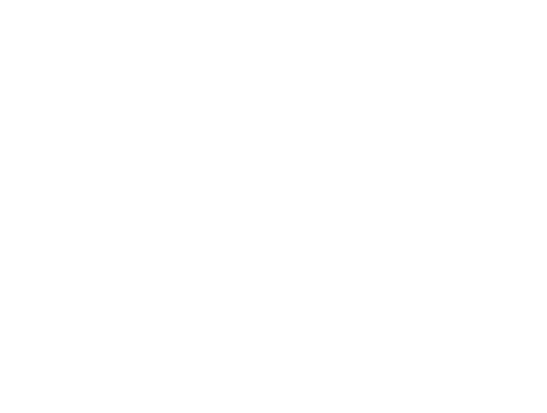

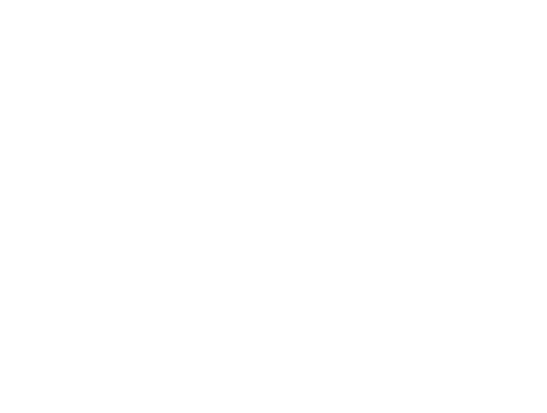

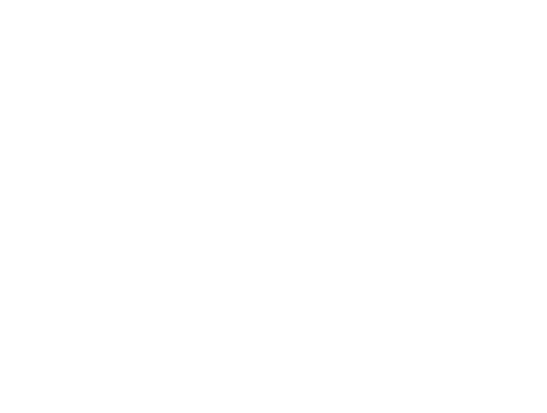

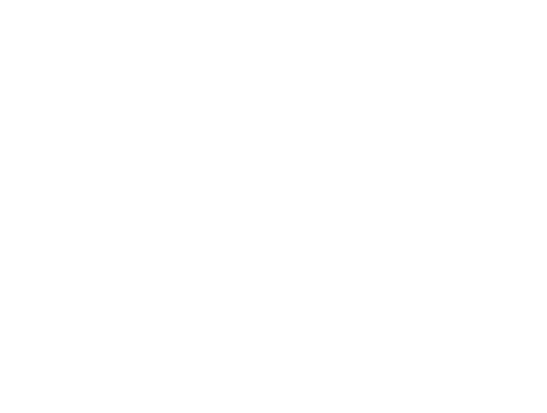

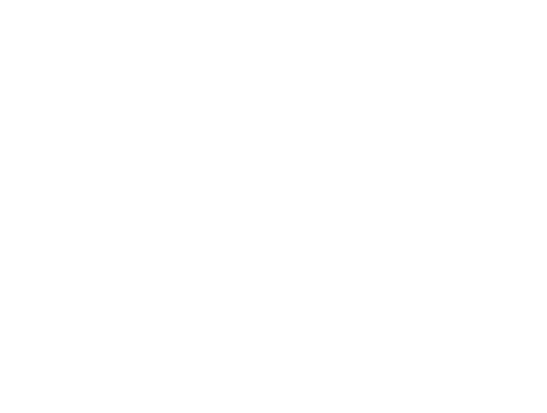

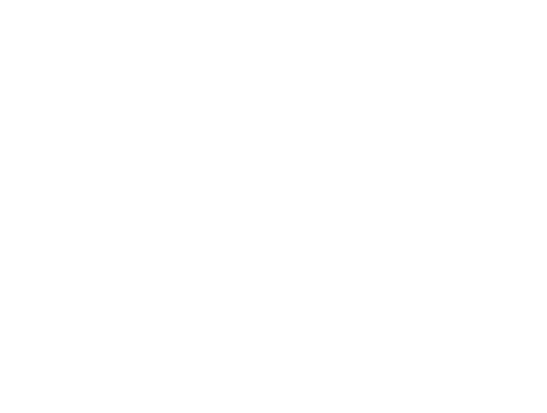

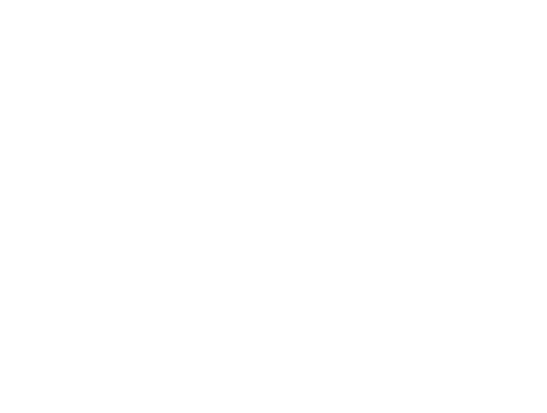

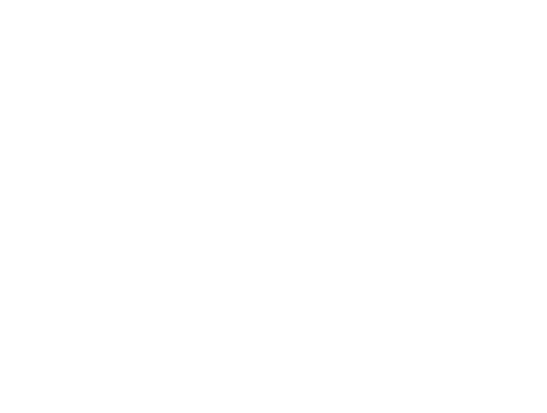

In [108]:
test_validation = validation_df[validation_df["scenario"] == "test"]
box_plot(test_validation, file_prefix="../pgfplots/mario_validation", y="final_percentage", x="short_set_up",
         groups=["solver", "difficulty"])

In [109]:
# p-values table
min_val = 0.001
alpha = 0.05
vals = ["C-PAR", "C-SEQ", "C-GRAD", "D-PAR", "D-SEQ"]
difficulties = ["Trivial", "Easy", "Medium", "Difficult"]
print("\\begin{tabular}{l|l|ccccc|ccccc}")
print("\\toprule")
print(" & & \\multicolumn{5}{c}{LGP} & \\multicolumn{5}{c}{CGP} \\\\")
print("\\midrule")
print(f"& & {' & '.join(vals)} & {' & '.join(vals)} \\\\")
print("\\midrule")

for difficulty in range(4):
    first_row_starter = "\\multirow{5}{*}{\\begin{tabular}{@{}c@{}}\\rotatebox{90}{" + difficulties[
        difficulty] + "}\\end{tabular}}"
    for y_idx, y_val in enumerate(vals):
        row = first_row_starter if y_idx == 0 else ""
        row += f" & {y_val}"
        for solver in ["lgp", "cgp"]:
            for x_idx, x_val in enumerate(vals):
                if x_val == y_val:
                    row += f" & \\color{{gray!30}}---"
                else:
                    m1_data = test_validation[(test_validation["solver"] == solver) &
                                              (test_validation["difficulty"] == difficulty) & (
                                                      test_validation["short_set_up"] == x_val)][
                        "final_percentage"].to_list()
                    m2_data = test_validation[(test_validation["solver"] == solver) &
                                              (test_validation["difficulty"] == difficulty) & (
                                                      test_validation["short_set_up"] == y_val)][
                        "final_percentage"].to_list()
                    _, pvalue = ranksums(m1_data, m2_data)
                    pvalue_string = f"{pvalue:.3f}" if pvalue >= min_val else "$\\mathbf{\\approx 0}$"
                    if min_val < pvalue < alpha:
                        pvalue_string = f"\\textbf{{{pvalue_string}}}"
                    if x_idx > y_idx:
                        row += f" & {pvalue_string}"
                    else:
                        row += f" & \\color{{gray!30}}{pvalue_string}"
        print(f"{row} \\\\")
    if difficulty < 3:
        print("\\midrule")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{l|l|ccccc|ccccc}
\toprule
 & & \multicolumn{5}{c}{LGP} & \multicolumn{5}{c}{CGP} \\
\midrule
& & C-PAR & C-SEQ & C-GRAD & D-PAR & D-SEQ & C-PAR & C-SEQ & C-GRAD & D-PAR & D-SEQ \\
\midrule
\multirow{5}{*}{\begin{tabular}{@{}c@{}}\rotatebox{90}{Trivial}\end{tabular}} & C-PAR & \color{gray!30}--- & $\mathbf{\approx 0}$ & 0.268 & 0.351 & $\mathbf{\approx 0}$ & \color{gray!30}--- & \textbf{0.002} & 0.124 & \textbf{0.041} & $\mathbf{\approx 0}$ \\
 & C-SEQ & \color{gray!30}$\mathbf{\approx 0}$ & \color{gray!30}--- & \textbf{0.003} & \textbf{0.003} & 0.832 & \color{gray!30}\textbf{0.002} & \color{gray!30}--- & $\mathbf{\approx 0}$ & 0.178 & 0.594 \\
 & C-GRAD & \color{gray!30}0.268 & \color{gray!30}\textbf{0.003} & \color{gray!30}--- & 0.773 & \textbf{0.002} & \color{gray!30}0.124 & \color{gray!30}$\mathbf{\approx 0}$ & \color{gray!30}--- & $\mathbf{\approx 0}$ & $\mathbf{\approx 0}$ \\
 & D-PAR & \color{gray!30}0.351 & \color{gray!30}\textbf{0.003} & \color{gray!30}0.773 & \

In [110]:
# ranks table

import math

print(
    "\\begin{tabular}{llp{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}c}")
print("\\toprule")
print(f" & & {' & '.join([str(i) for i in range(1, 16)])} & Sum \\\\")
print("\\midrule")

for solver in ["lgp", "cgp"]:
    first_row_starter = "\\multirow{5}{*}{\\begin{tabular}{@{}c@{}}\\rotatebox{90}{" + solver.upper() + "}\\end{tabular}}"
    for idx, method in enumerate(["C-PAR", "C-SEQ", "C-GRAD", "D-PAR", "D-SEQ"]):
        ddf = rank_df[(rank_df["short_set_up"] == method) & (rank_df["solver"] == solver)].sort_values(
            by=["difficulty"], ascending=True)
        string_values = "" if idx > 0 else first_row_starter
        string_values += (
                " & " + method + " & " + " & ".join([str(math.floor(x)) for x in ddf["rank"].tolist()])).replace("1",
                                                                                                                 "\\textbf{1}")
        string_values += f" & {math.floor(sum(ddf['rank'].tolist()))} \\\\"
        print(string_values)
        if idx == 4 and solver == "lgp":
            print("\\midrule")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{llp{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}p{0.18cm}c}
\toprule
 & & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & Sum \\
\midrule
\multirow{5}{*}{\begin{tabular}{@{}c@{}}\rotatebox{90}{LGP}\end{tabular}} & C-PAR & 2 & \textbf{1} & 2 & \textbf{1} & \textbf{1} & 3 & \textbf{1} & \textbf{1} & \textbf{1} & 3 & 3 & \textbf{1} & 3 & \textbf{1} & \textbf{1} & 27 \\
 & C-SEQ & \textbf{1} & 5 & 4 & 5 & 3 & 4 & 4 & 5 & \textbf{1} & 4 & 4 & 4 & 5 & 5 & 4 & 59 \\
 & C-GRAD & 4 & 3 & \textbf{1} & \textbf{1} & 5 & \textbf{1} & \textbf{1} & 3 & 4 & \textbf{1} & 2 & \textbf{1} & 2 & 2 & 4 & 37 \\
 & D-PAR & 3 & 2 & 3 & 3 & 3 & 2 & 4 & 2 & 3 & 2 & \textbf{1} & 4 & \textbf{1} & 3 & 2 & 39 \\
 & D-SEQ & 5 & 4 & 5 & 3 & 2 & 5 & 4 & 4 & 4 & 5 & 5 & 4 & 4 & 3 & 4 & 62 \\
\midrule
\multirow{5}{*}{\begin{tabular}{@{}c@{}}\rotatebox{90}{CGP}\end{tabular}} & C-PAR & 3 & 3 & 2 & 2 & 2 & 2 & 2

In [111]:
# for difficulty in rank_df["difficulty"].unique():
#     first_method_list = rank_df[(rank_df["difficulty"] == difficulty) & (rank_df["rank"] == 1)]["short_set_up"].tolist()
#     if len(first_method_list) == 0:
#         continue
#     first_method = first_method_list[0]
#     print(f"{difficulty} --> {first_method}")
#     other_methods = rank_df[(rank_df["difficulty"] == difficulty) & (rank_df["rank"] > 1)]["short_set_up"].tolist()
#     for other_method in other_methods:
#         pvalue = original_pvalues_df[
#             ((original_pvalues_df["m1"] == first_method) & (original_pvalues_df["m2"] == other_method)) | (
#                     original_pvalues_df["m2"] == first_method) & (original_pvalues_df["m1"] == other_method)][
#             "pvalue"].tolist()[0]
#         print(f"{other_method} - {pvalue}")